<a href="https://colab.research.google.com/github/echoheqian/drug-target-master/blob/main/0520.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')
sys.setrecursionlimit(1000000)

In [3]:
# set a seed for code reproducibility
SEED = 7
np.random.seed(SEED)
pd.set_option('display.max_columns', 180)

In [4]:
# 2.1 Loading data
df = (pd.read_csv('pheno.prs.0421.csv', sep="\t")
        .query('dm_trial==True')
        .drop('dm_trial', axis=1))
df.shape 

(5832, 338)

In [5]:
# define cvd incidece rate 
def get_cvd_type(x):
  if x['mi'] == 1 or x['chd'] ==1 or x['dm'] ==1 or x['isch_stroke']==1 or x['hemo_stroke']==1:
    return 1
  else: 
    return 0
df.loc[:, 'cvd_binary'] = df.apply(get_cvd_type, axis=1)
print(df['cvd_binary'].value_counts())

0    4473
1    1359
Name: cvd_binary, dtype: int64


In [6]:
# change missing values of -9 defined previously
df['baseline_sleep'].replace(-9, np.nan, inplace = True)

In [7]:
# 2.2 detecting missing values
## define count missing values function
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
## count missing values
df_missing = missing_values_table(df)
df_missing

In [ ]:
# detect missing values >40%
df_50_missing = df_missing[df_missing['% of Total Values'] > 40]
df_50_missing.index

In [10]:
## delete variables with missing values higher than 50%
missing_vars = df_50_missing.index
df_update = (df.drop(missing_vars,axis=1))

In [ ]:
# 更新数据集，删除fid,iid,subjid,visit_year,time_to_event之类的列
drop_cols = ['subjID','FID','IID','time_to_chd','time_to_isch_stroke','time_to_hemo_stroke','time_to_death','time_to_cvd_death',
             'time_to_non_cvd_death','time_to_dm','time_to_mi','time_to_cancer','visit_year','SCORE_delta_sleep_p1_0.05','SCORE_delta_ces_d_p0.05_0.05',
             'SCORE_delta_sleep_p0.05_0.001','SCORE_baseline_sleep_p1_0.05','SCORE_igap_p0.05','SCORE_inso','SCORE_mdd','SCORE_igap',
             'SCORE_baseline_ces_d_p1e5','SCORE_baseline_sleep_p1e5','SCORE_baseline_ces_d_p1','sugar_pct_binary','sugar','SCORE_sugar_baseline_sleep_p0.05',
             'SCORE_sugar_baseline_sleep_p1','SCORE_sugar_baseline_sleep_p1e5','SCORE_sugar_baseline_mse_p1','SCORE_sugar_baseline_mse_p0.05',
             'SCORE_sugar_baseline_mse_p1e5','SCORE_sugar_baseline_ces_d_p1','SCORE_sugar_baseline_ces_d_p0.05','SCORE_sugar_baseline_ces_d_p1e5','race','sex',
             'MENSELST','MEALOUT','DIAB']
df_update1= (df_update.drop(columns=drop_cols))
df_update1.head()

In [ ]:
# get column names of missing variables
missing_variables = df_update1.isnull().columns
print(missing_variables)

In [13]:
# 可视化缺失值
import matplotlib.pyplot as plt
import pylab as pl
# 统计缺失值数量
missing=df_update1.isnull().sum().reset_index().rename(columns={0:'missNum'})
# 计算缺失比例
missing['missRate']=missing['missNum']/df_update1.shape[0]
# 按照缺失率排序显示
miss_analy=missing[missing.missRate>0].sort_values(by='missRate',ascending=False)
# miss_analy 存储的是每个变量缺失情况的数据框

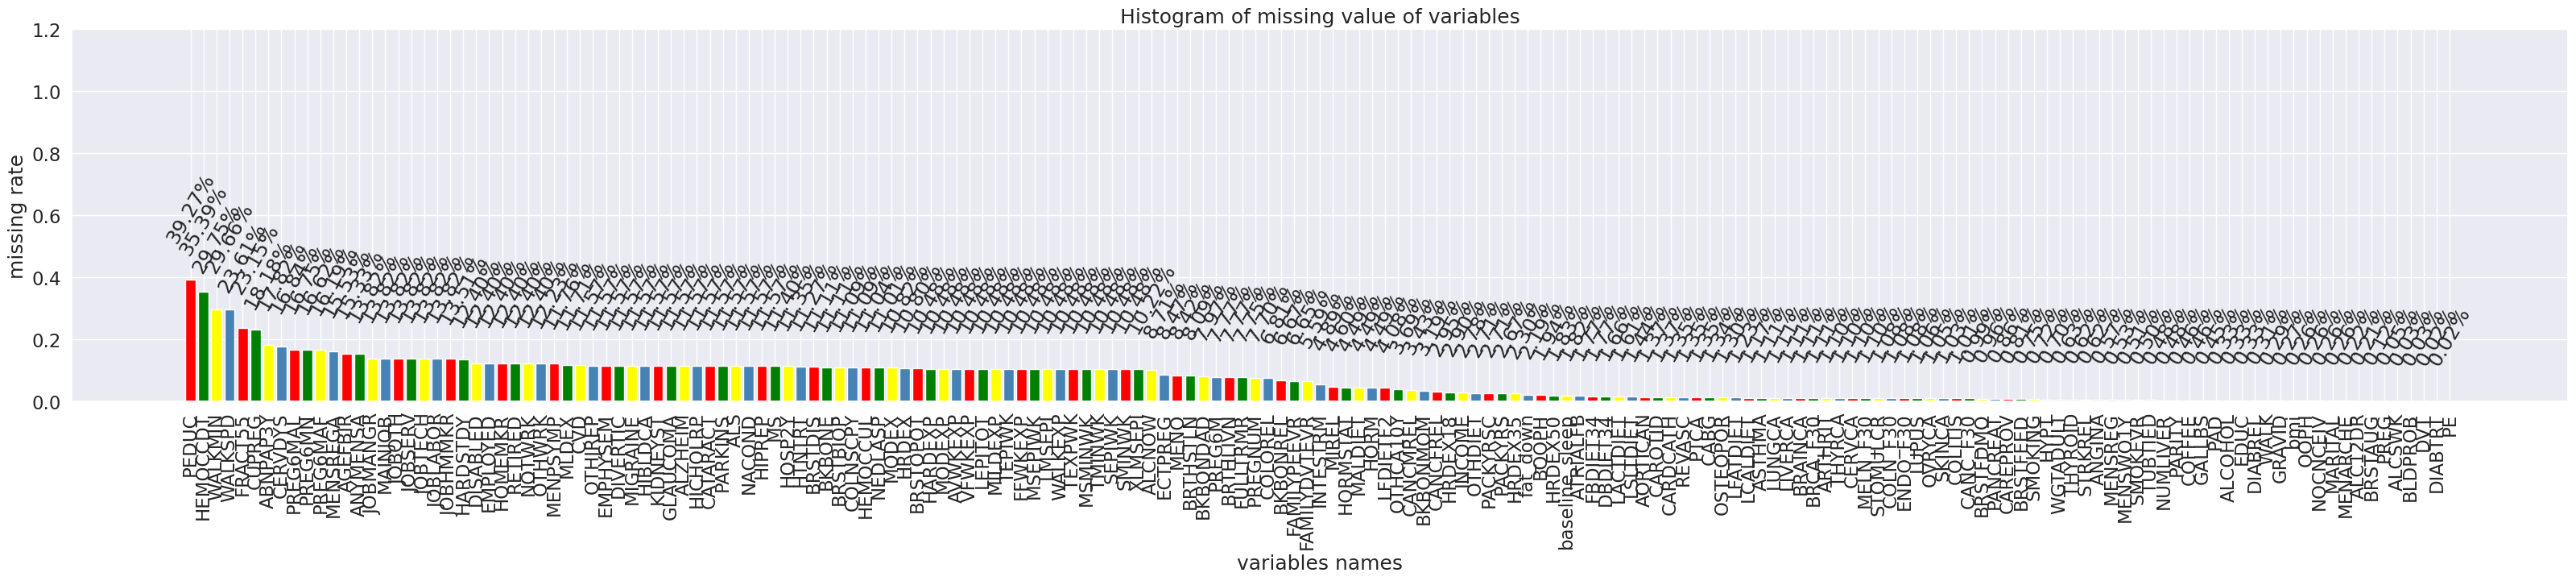

In [89]:
fig = plt.figure(figsize=(40,6))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align = 'center',
        color=['red','green','yellow','steelblue'])

plt.title('Histogram of missing value of variables')
plt.xlabel('variables names')
plt.ylabel('missing rate')
# 添加x轴标签，并旋转90度
plt.xticks(np.arange(miss_analy.shape[0]),list(miss_analy['index']))
pl.xticks(rotation=90)
# 添加数值显示
for x,y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x,y+0.12,'{:.2%}'.format(y),ha='center',rotation=60)    
plt.ylim([0,1.2])
    
plt.show()

In [15]:
# 查看缺失值的数据类型，为后续不同类型填充策略做准备
missing_variables = df_update1.columns[df_update1.isnull().any()]
missing_df = df_update1[missing_variables]

In [16]:
missing_df.dtypes.value_counts()

float64    165
object      10
dtype: int64

In [ ]:
# 定义热图函数，查看不同缺失值之间的关联
def HeatMap(df, x=True):
  correlations = df.corr()
  ## creat color map ranging between two colors
  ## diverging_palette()为创建两种颜色过渡色板
  cmap = sns.diverging_palette(100, 10,as_cmap=True)
  fig, ax = plt.subplots(figsize=(35,35))
  ## heatmap中参数: vmin和vmax定义图卡颜色，用于锚定颜色图的值
  # cmap 颜色映射名称或对象; fmt 添加注释时要使用的字符串格式化代码
  #fmt='.2f',当Annot为TRUE时才有用，显示数值的小数点位数
  fig = sns.heatmap(correlations, cmap=cmap, vmax=1.0, vmin=-1.0,
                    square=True,linewidths=.05, 
                    annot=False, cbar_kws={'shrink': .25})
                   #mask = abs(correlations) <0.9 )
  fig.set_xticklabels(fig.get_xticklabels(), rotation = 90, fontsize = 9)
  fig.set_yticklabels(fig.get_yticklabels(), rotation = 0, fontsize = 9)
  plt.tight_layout()
  plt.show()
HeatMap(missing_df,x=True)

In [ ]:
#查看缺失值之间的关联性，删除关联系数 >0.9的变量
missing_cor = missing_df.corr()
sub_missing_cor = []
for index in missing_cor.index:
  for i in range(len(missing_cor.loc[index].values)):
     if((missing_cor.loc[index].values[i] >= 0.9) & (missing_cor.loc[index].values[i]<1)):
 #sub = missing_cor.where((np.abs(missing_cor[i]).isin(0.9,1), print(missing_cor.loc[i,i])))
     #sub_missing_cor.append(sub)
        print(index, i)
        print(missing_cor.loc[index].values[i])

In [19]:
df_update1 = (df_update1.drop(columns=['MSMINWK','HTNTRT','BRTHLIVN','PARITY','BRSTDIS','SMOKING','NUMLIVER','SEPIWK','TMINWK','TEXPWK','HARDEXP']))

In [ ]:
# 查看缺失值的数据类型，为后续不同类型填充策略做准备
missing_variables = df_update1.columns[df_update1.isnull().any()]
missing_df =  df_update1[missing_variables]
HeatMap(missing_df,x=True)

In [21]:
missing_values_table(df_update1)

Your selected dataframe has 217 columns.
There are 164 columns that have missing values.


,Missing Values,% of Total Values
PEDUC,2290,39.3
HEMOCCDT,2064,35.4
WALKMIN,1735,29.7
WALKSPD,1730,29.7
FRACT55,1377,23.6
...,...,...
ALCSWK,3,0.1
BLDPROB,2,0.0
DVT,2,0.0
DIABTRT,1,0.0


In [22]:
df_update1[missing_variables].dtypes.value_counts()

float64    154
object      10
dtype: int64

In [25]:
### 将缺失列中的文本数据填充为NAN为连续变量插入缺失值
df_update2 = df_update1.replace('amind', np.nan)
df_update3 = df_update2.replace('asian',np.nan)
df_update3[missing_variables].dtypes.value_counts()

float64    154
object      10
dtype: int64

In [90]:
df_update3.to_csv('pheno.prs.0520.csv', sep=",", index = False)

In [26]:
## 将连续变量和分类变量分开填充
## example 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.base import TransformerMixin

In [ ]:
### 区分数据中的数值变量和离散变量，对不同的变量类型分别采用不同的填充策略
## O_index:   数值变量列名
##C :离散变量列名
def distinguish_Char_Num(DataFrame_data):
  import copy
  m, n = DataFrame_data.shape
  O = []
  C = []
  data = copy.deepcopy(DataFrame_data)
  for i in range(n):
    try:
      if isinstance(data.iloc[0, i], int) or isinstance(data.iloc[0, i], float) or isinstance(data.iloc[0, i],  np.float64)  or isinstance(data.iloc[0, i], np.int64) or isinstance(data.iloc[0, i], np.int32):
          O.append(i)
      elif isinstance(data.iloc[0, i], object):
          C.append(i)
      else:
            raise ValueError("the %d colum of data is ot a umber or object")
    except TypeError as e:
          print(e)
  O_data = copy.deepcopy(data.iloc[:, O])
  C_data = copy.deepcopy(data.iloc[:, C])
  O_index = O_data.columns.tolist()
  C_index = C_data.columns.tolist()
  return O_index, C_index
# 取得两类变量类型的名称
O_index, C_index = distinguish_Char_Num(df_update3[missing_variables])
# 连续变量 
O_index
# 离散变量
C_index

In [40]:
df_update3.iloc[:,1].unique()

array([0, 1])

In [ ]:
### 方法二： 区分数据中的数值变量和离散变量，对不同的变量类型分别采用不同的填充策略
def check_var(DataFrame_data):
  import copy
  m, n = DataFrame_data.shape
  O1 = []
  C1 = []
  data = copy.deepcopy(DataFrame_data)
  for i in range(n):
      if len(data.iloc[:,i].unique()) > 10:
          O1.append(i)
      else:
          C1.append(i)
  O1_data = copy.deepcopy(data.iloc[:, O1])
  C1_data = copy.deepcopy(data.iloc[:, C1])
  O1_index = O1_data.columns.tolist()
  C1_index = C1_data.columns.tolist()
  return O1_index, C1_index
# 取得两类变量类型的名称
O1_index, C1_index = check_var(df_update3[missing_variables])
# 连续变量 
O1_index
# 离散变量
C1_index

In [42]:
# 填补缺失值数据类型为OBJECT类型的分类变量数据，填补的方法为填充为类别多的值
class DataFrameImputer(TransformerMixin):
  def _init_(self):
    """Impute missing values.
     Columns of dype object are imputed with MICE category variables in columns.
     Columns of float types are imputed with MICE continueous variables in columns.
    """
  def fit(self, X, y=None):
      self.fill = pd.Series([X[c].value_counts().index[0] 
                      if X[c].dtypes == 'O' else np.nan for c in X],
              index = X.columns)
      
      return self

  def transform(self, X, Y=None):
        return X.fillna(self.fill)
xt_obj_complete = DataFrameImputer().fit_transform(df_update3)
xt_obj_complete.dtypes.value_counts()
missing = missing_values_table(xt_obj_complete)

Your selected dataframe has 217 columns.
There are 154 columns that have missing values.


In [43]:
## 填补经UNIQUE判断出的分类变量数据，填补类型为中位数
# C1_index 为分类数据
print(C1_index)
for col_name in C1_index:
    xt_obj_complete[col_name] = xt_obj_complete[col_name].fillna(xt_obj_complete.loc[xt_obj_complete[col_name].isnull() == False, col_name].median())

In [44]:
### 采用均值填充缺失值比例<2%的连续变量
# 筛选出缺失值比例< 2%的变量，直接用均值填充
O1_index_low = missing[(missing['% of Total Values'] < 2) ].index
print(O1_index_low)
for col_name in O1_index_low:
      xt_obj_complete[col_name] = xt_obj_complete[col_name].fillna(xt_obj_complete.loc[xt_obj_complete[col_name].isnull() == False, col_name].mean())

Index(['HRDEX50', 'baseline_sleep', 'ATRIALFB', 'DBDIET34', 'FBDIET34',
       'LACTDIET', 'LSLTDIET', 'AORTICAN', 'CAROTID', 'CARDCATH', 'REVASC',
       'CABG', 'PTCA', 'OSTEOPOR', 'LFATDIET', 'LCALDIET', 'ASTHMA', 'ARTHRIT',
       'LUNGCA', 'LIVERCA', 'BRAINCA', 'BRCA_F30', 'STOMULCR', 'THYRCA',
       'MELN_F30', 'CERVCA', 'COLN_F30', 'LUPUS', 'ENDO_F30', 'OVRYCA',
       'SKINCA', 'COLITIS', 'CANC_F30', 'BRSTFDMO', 'PANCREAT', 'CAREPROV',
       'BRSTFEED', 'HYPT', 'WGTADULT', 'THYROID', 'STRKREL', 'ANGINA',
       'MENSREG', 'MENSWO1Y', 'SMOKEVR', 'TUBTIED', 'COFFEE', 'GALLBS', 'PAD',
       'DIABREL', 'EDUC', 'ALCOHOL', 'WALK', 'GRAVID', 'bmi', 'MENARCHE',
       'NOCNCEIV', 'OOPH', 'MARITAL', 'ALC12DR', 'BRSTAUG', 'PREG', 'ALCSWK'],
      dtype='object')


In [ ]:
# 再核对一遍填充数据的效果
missing_values_table( xt_obj_complete)

In [62]:
# 删除其他cvd的患病情况
cvd_vars = ['chd','isch_stroke','hemo_stroke','death','cvd_death','non_cvd_death','cancer','cvd_binary']
df_update4= (xt_obj_complete.drop(cvd_vars, axis=1))
df_name = df_update4.columns
df_name

Index(['mi', 'fat_down', 'multi_supp', 'multi_supp_mineral', 'stress_supp',
       'mix_supp', 'SCORE_baseline_sleep_p0.05_0.05', 'sugar_pct',
       'baseline_sugar', 'SCORE_inso_all_group',
       ...
       'VFWKEXP', 'ALCSWK', 'ALCOHOL', 'PACKYRS', 'PACKYRSC', 'FAMILYDVTEVR',
       'FAMILYPEEVR', 'sbp', 'dbp', 'bmi'],
      dtype='object', length=209)

In [47]:
### 采用MICE方法填充连续变量
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

In [ ]:
# 方法二：创建建模通道，历遍不同参数，看哪个参数的效果最好
from matplotlib import pyplot
#LR_results = list()
LR_AUC_results = list()
#strategies = ['ascending','descending','roman','arabic','random']wertyuiop
strategies = [str(i) for i in range(1,30)]
#strategy = [str[i] for i i rage(1,50)]
for s in strategies: 
#  for s in strategy:
     model = LogisticRegression(solver='newton-cg', class_weight='balanced')
     #imputer = IterativeImputer(max_iter=int(s))
   #  scaler = StandardScaler()
     pipeline1 = Pipeline(steps = [('i',imputer), ('m', model)])
     cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=2, random_state=1)
# 评估模型
     scores_auc =  cross_val_score(pipeline1, X_train, y_train,
												 scoring='roc_auc',
												 cv=cv , 
                         n_jobs=-1,
                         error_score = 'raise')
    #LR_results.append(scores)
     LR_AUC_results.append(scores_auc)
     print('>%s %.3f (%.3f)' % (s, mean(scores_auc), std(scores_auc)))

In [59]:
def HeatMap(df, x=True):
  correlations = df.corr()
  ## creat color map ranging between two colors
  ## diverging_palette()为创建两种颜色过渡色板
  cmap = sns.diverging_palette(220, 10,as_cmap=True)
  fig, ax = plt.subplots(figsize=(20,20))
  ## heatmap中参数: vmin和vmax定义图卡颜色，用于锚定颜色图的值
  # cmap 颜色映射名称或对象; fmt 添加注释时要使用的字符串格式化代码
  # fmt='.2f',
  fig = sns.heatmap(correlations, cmap=cmap, vmax=1.0, vmin=-1.0,
                    square=True,linewidths=.5, 
                    annot=False, cbar_kws={'shrink': .75})
  fig.set_xticklabels(fig.get_xticklabels(), rotation = 60, fontsize = 10)
  fig.set_yticklabels(fig.get_yticklabels(), rotation = 0, fontsize = 10)
  plt.tight_layout()
  plt.show()

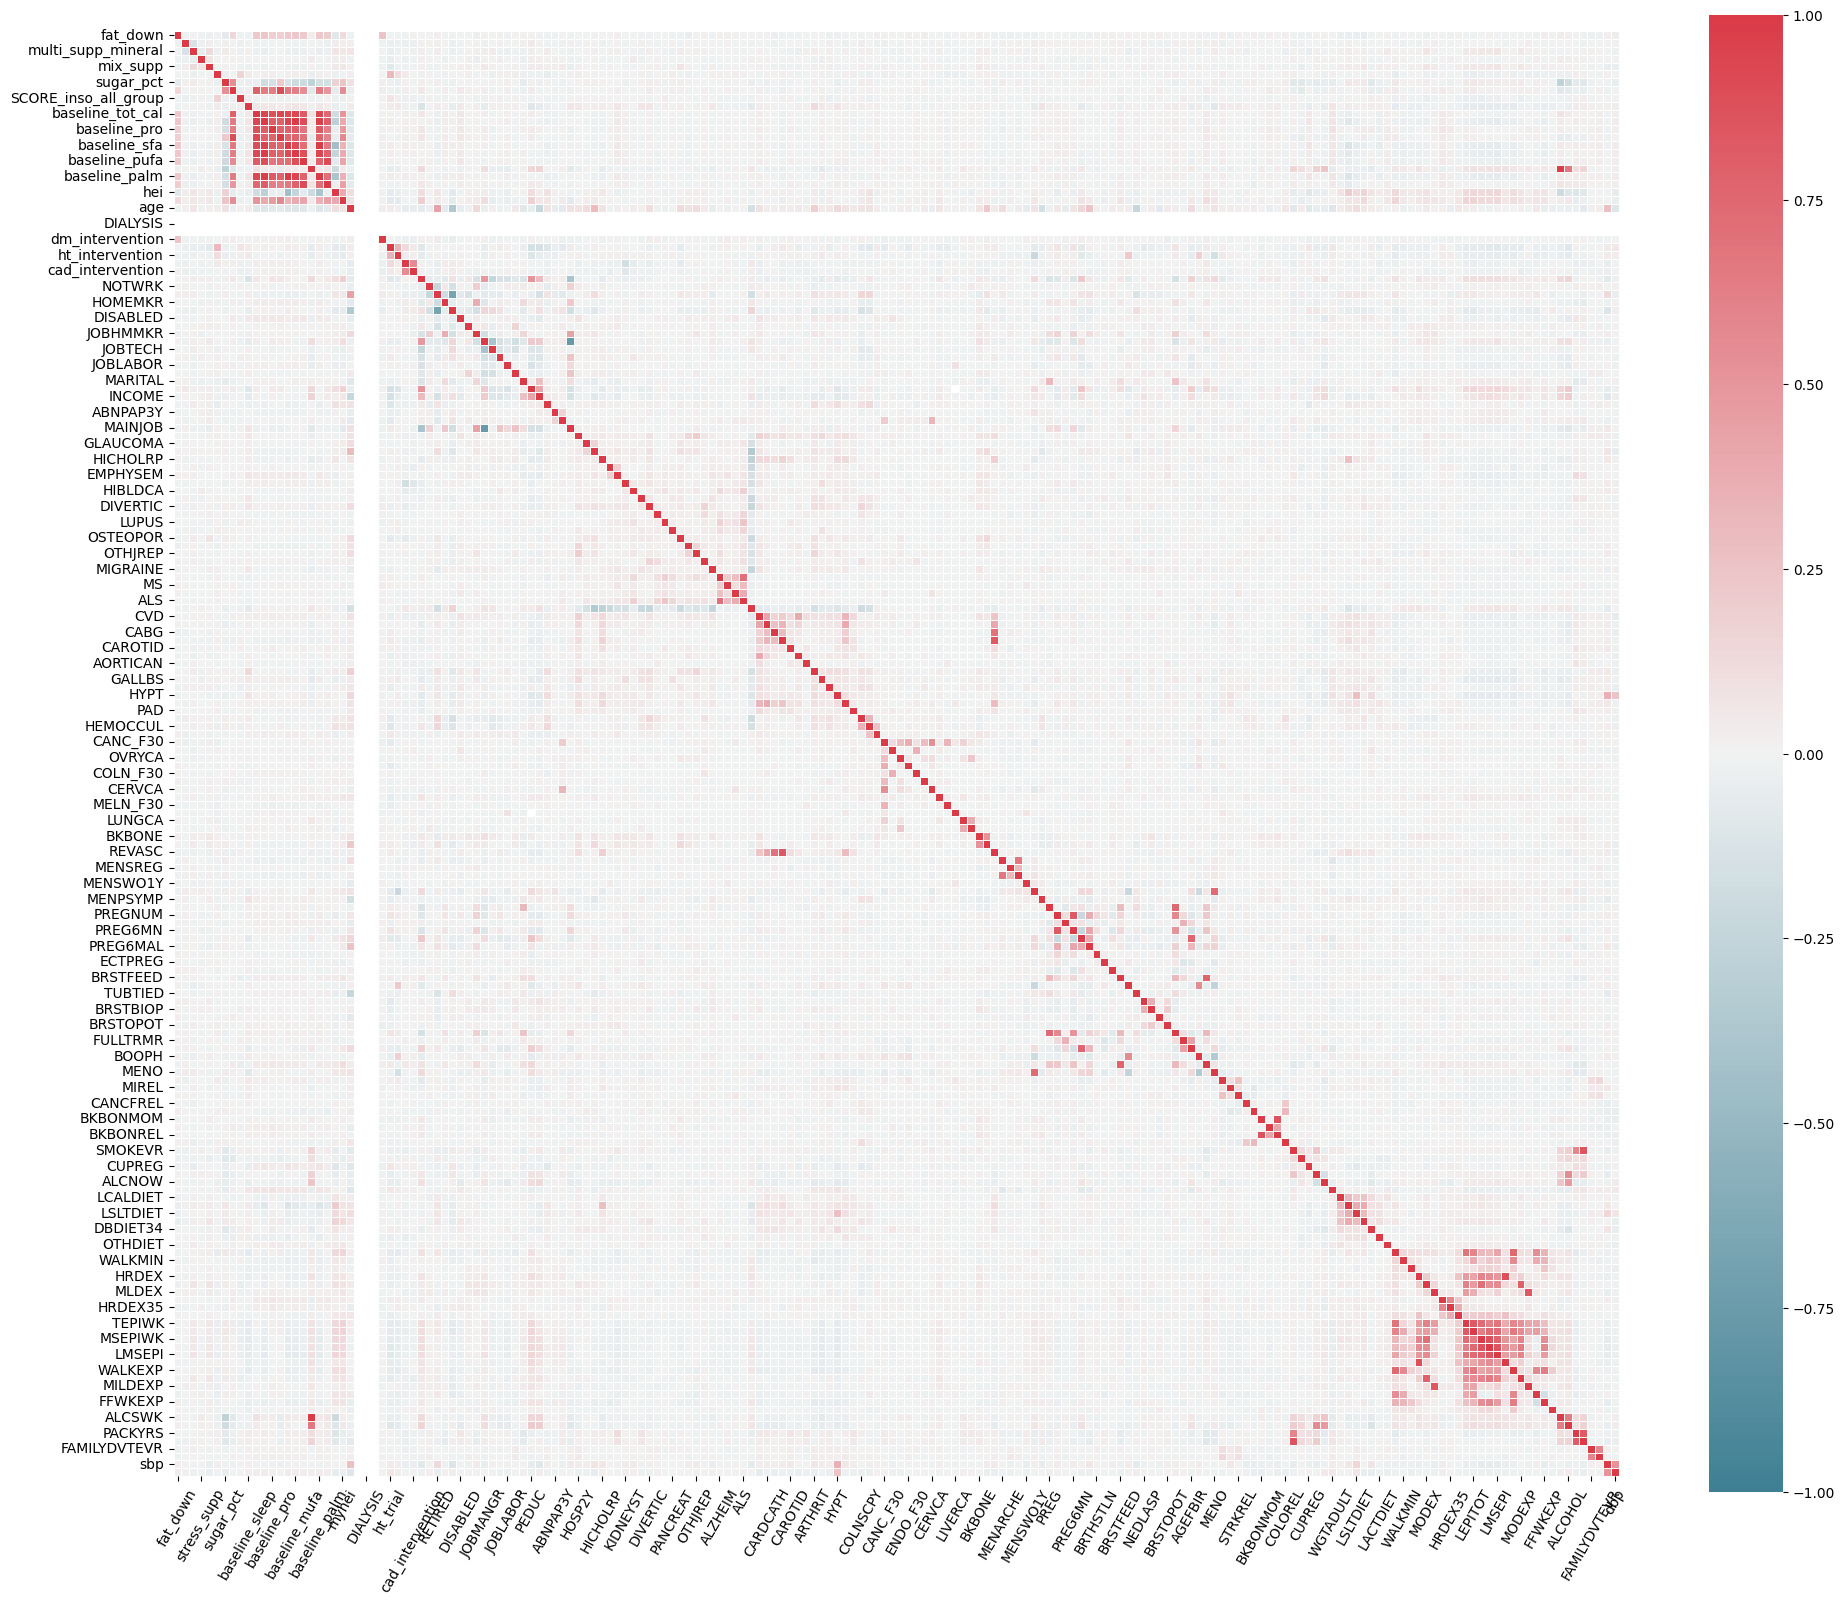

In [60]:
HeatMap(X)

In [51]:
# Load libraries
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler

In [56]:
df_update4['mi'].value_counts()
df_name=df_update4.columns

In [49]:
df_update4.shape

(5832, 209)

In [67]:
X = df_update4[df_name[1:208]]
Y = df_update4[df_name[0]]

In [68]:
## 划分数据集
#X = df_update4[feature_index]
#Y = df_update4[df_name[0]]
X_train, X_test, y_train, y_test = train_test_split(
    X,Y,
    test_size=0.3,
    random_state=0,
    stratify=Y
)

In [55]:
print("There are {} training samples".format(y_train.shape[0]))
print("There are {} testing samples".format(X_test.shape[0]))

There are 4082 training samples
There are 1750 testing samples


In [61]:
# 方法一：采用固定参数 进行多重插补填充缺失值
mice_imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=5)

#['insu','ldl','hdl','chol','tg','glu','sbp','dbp',
variables =  missing_values_table(xt_obj_complete).index
for i in variables:
  xt_obj_complete[i] = mice_imputer.fit_transform(xt_obj_complete[[i]])

Your selected dataframe has 217 columns.
There are 15 columns that have missing values.


In [71]:
# load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation


In [72]:
## ExtraTreesClassifier 它将森林中收集的多个去相关决策树的结果聚集起来输出分类结果
clf = ExtraTreesClassifier(n_estimators=250,
                              random_state=SEED)

clf.fit(X_train, y_train)

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_idx_30 = sorted_idx[0:30]
pos = np.arange(sorted_idx.shape[0]) + .5
pos_30 = pos[0:30]


In [74]:
df_update4.columns[sorted_idx]

Index(['FBDIET34', 'FAMILYPEEVR', 'myhei', 'mix_supp', 'MENSWO1Y', 'BRSTFDMO',
       'baseline_n3', 'WALKMIN', 'baseline_tot_cal', 'hei',
       ...
       'PE', 'DVT', 'LFDIETF2', 'MALDIET', 'HYST', 'HORM', 'OTHCA10Y',
       'MELAN_F2', 'SKIN_F2', 'LUNGCA'],
      dtype='object', length=207)

In [ ]:
# 构建排序后的特征
sortindex = np.argsort(clf.feature_importances_)[::-1]
feature_index = []
for i in sortindex:
  if clf.feature_importances_[i] > 0.008:
      feature_index.append(df_update4.columns[i])
      print('%s\t%.5f'%(df_update4.columns[i], clf.feature_importances_[i]))

In [ ]:
feature_index

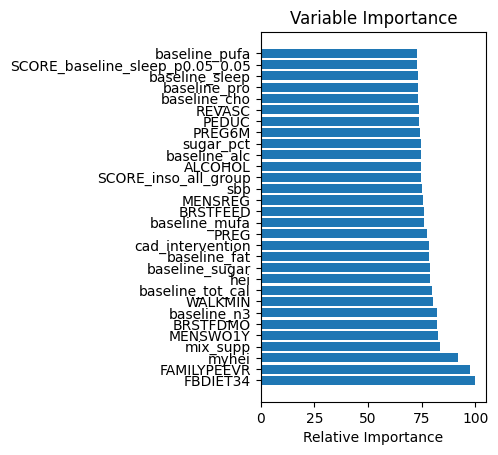

In [78]:
plt.subplot(1, 2, 2)
plt.barh(pos_30, feature_importance[sorted_idx_30], align='center')
plt.yticks(pos_30, df_update4.columns[sorted_idx_30], fontsize =10)#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [104]:
# Building Decision Tree Model
# create Decision Tree classifer object
Tree = DecisionTreeClassifier(random_state=0)

# train decision tree classifer
Tree.fit(X_train, y_train)
features = X_train.columns
# 交叉验证评估
score1 = cross_val_score(Tree, X_train, y_train, cv = 5).mean()
score2 = Tree.score(X_test, y_test)
print(score1)
print(score2)
# 查看数据集分布是否平衡，如不平衡，可以采用sample_weight设置
y_train.value_counts()

0.8628047975616194
0.8714285714285714


0    3806
1     276
Name: mi, dtype: int64

In [ ]:
# 选择2: 采用网格搜索调整参数
param = {'max_depth':[*range(1,10)],
         'splitter':('best','random'),
         'criterion':('gini','entropy'),
         'min_impurity_decrease':[*np.linspace(0,0.5,20)],
         'min_samples_leaf':[*range(1,50,5)] # 2
         }
Tree = DecisionTreeClassifier(random_state=0)
GS = GridSearchCV(Tree, param, cv=5)
GS.fit(X_train, y_train)
print(GS.best_params_)
print(GS.best_score_)

In [84]:
# 导入和训练模型
lr = LogisticRegression(solver='newton-cg', class_weight='balanced')
# 可选择的class_weight 有 balnaced, balanced_subsample, 
## calculate weight Calculate weights using sklearn

rf = RandomForestClassifier(class_weight='balanced_subsample')

# 对训练数据集进行标准化
ss = StandardScaler()
#X_train_new = X_train[['DBDIET34', 'REVASC', 'ANGINA', 'ht_trial', 'LCALDIET', 'HEMOCCDT', 'MSMINWK','SCORE_baseline_sleep_p0.05_0.05']]
X_train_new = ss.fit_transform(X_train)

# 拟合模型
lr.fit(X_train_new, y_train)
rf.fit(X_train_new, y_train)

# 测试数据预测
pred_test = lr.predict(X_test)
pred_test_rf = rf.predict(X_test)

The f1 score for the testing data: 0.12734082397003746
The f1 score for the testing data: 0.0
Classfication report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1631
           1       0.07      1.00      0.13       119

    accuracy                           0.07      1750
   macro avg       0.03      0.50      0.06      1750
weighted avg       0.00      0.07      0.01      1750

Classfication report: 
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1631
           1       0.00      0.00      0.00       119

    accuracy                           0.93      1750
   macro avg       0.47      0.50      0.48      1750
weighted avg       0.87      0.93      0.90      1750



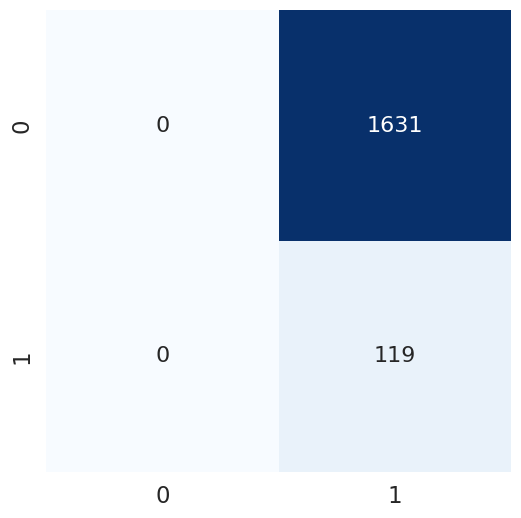

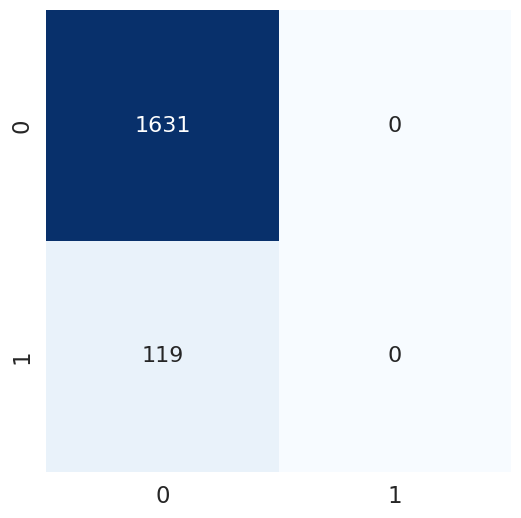

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

# 创建混淆矩阵的函数
def conf_matrix(y_test, pred_test):
  # 创建混淆矩阵
  con_mat = confusion_matrix(y_test, pred_test)
  con_mat = pd.DataFrame(con_mat, range(2), range(2))

  plt.figure(figsize=(6,6))
  sns.set(font_scale=1.5)
  sns.heatmap(con_mat, annot=True, annot_kws={'size':16}, fmt='g',cmap='Blues', cbar=False)
# 调用函数

#计算并打印f1分数
f1_test = f1_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)

f1_test_rf = f1_score(y_test, pred_test_rf)
print('The f1 score for the testing data:', f1_test_rf)

# 绘制混淆矩阵
print('Classfication report: \n', classification_report(y_test, pred_test))
conf_matrix(y_test, pred_test)

print('Classfication report: \n', classification_report(y_test, pred_test_rf))
conf_matrix(y_test, pred_test_rf)


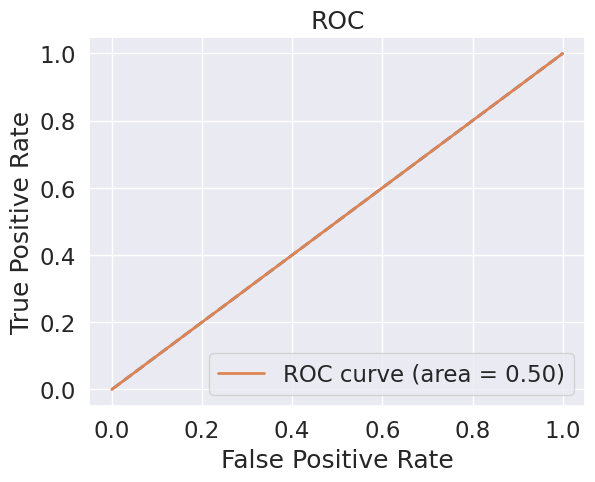

In [88]:
# 绘制AUC-ROC曲线
# ROC Curve with logistic regression
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
y_pred = lr.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
# plot ROC vurve
plt.figure()
lw = 2
plt.plot([0,1],[0,1], lw = lw, linestyle = '--')
plt.plot(fpr, tpr, lw = lw, label = 'ROC curve (area = %0.2f)' % auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc ="lower right")
plt.show()

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def GetScaledModel(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()

    pipelines = []
    pipelines.append((nameOfScaler+'_LR'  , Pipeline([('Scaler', scaler),('LR'  , LogisticRegression(solver='newton-cg', class_weight = "balanced"))])))
    pipelines.append((nameOfScaler+'_LDA' , Pipeline([('Scaler', scaler),('LDA' , LinearDiscriminantAnalysis())])))
    pipelines.append((nameOfScaler+'_KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfScaler+'_CART', Pipeline([('Scaler', scaler),('CART', DecisionTreeClassifier())])))
    pipelines.append((nameOfScaler+'_NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
    pipelines.append((nameOfScaler+'_SVM' , Pipeline([('Scaler', scaler),('SVM' , SVC())])))
    pipelines.append((nameOfScaler+'_AB'  , Pipeline([('Scaler', scaler),('AB'  , AdaBoostClassifier())])  ))
    pipelines.append((nameOfScaler+'_GBM' , Pipeline([('Scaler', scaler),('GMB' , GradientBoostingClassifier())])  ))
    pipelines.append((nameOfScaler+'_RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestClassifier())])  ))
    pipelines.append((nameOfScaler+'_ET'  , Pipeline([('Scaler', scaler),('ET'  , ExtraTreesClassifier())])  ))


    return pipelines 

In [81]:
####                             
# Spot-Check Algorithms
# LR, LDA, NB 三种模型的RECALL还可以，可以考虑重点关注该三种模型，采用FOR循环调参
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression(solver='newton-cg', class_weight='balanced')))
    basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
    basedModels.append(('KNN'  , KNeighborsClassifier()))
    basedModels.append(('CART' , DecisionTreeClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    basedModels.append(('SVM'  , SVC(probability=True)))
    basedModels.append(('AB'   , AdaBoostClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))

    
    return basedModels
def BasedLine2(X_train, y_train, models):
  # Test options and evaluation metric
  num_folds = 10
  # score 的类型可以选择"accuracy"，"roc_auc", "f1", "precesion", "recall"
  scoring = "recall"
  results = []
  names = []
  # StratifiedKFold 保证训练集中每一类的比例是相同的,其中参数含义：n_splits为折叠次数,shuffle: 是否在每次分割之前打乱顺序
  # cross_val_score 为交叉验证函数，其中参数含义，cv为每次选择验证折数 
  for name, model in models:
    kfold = StratifiedKFold(n_splits=num_folds, random_state=SEED,shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
  return names, results
## 
class PlotBoxR(object):
    
    
    def __Trace(self,nameOfFeature,value): 
    
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def PlotResult(self,names,results):
        data = []

        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))
        py.iplot(data)


In [82]:
models = GetBasedModel()
names,results = BasedLine2(X_train[feature_index], y_train, models)

LR: 0.500397 (0.098285)
LDA: 0.086640 (0.050861)
KNN: 0.003704 (0.011111)
CART: 0.079365 (0.034574)
NB: 0.119180 (0.055219)
SVM: 0.000000 (0.000000)
AB: 0.025529 (0.023536)
GBM: 0.018122 (0.024160)
RF: 0.000000 (0.000000)
ET: 0.003571 (0.010714)


In [80]:
models = GetScaledModel('standard')
names,results = BasedLine2(X_train, y_train, models)
PlotBoxR().PlotResult(names, results)

standard_LR: 0.608322 (0.060156)
standard_LDA: 0.638602 (0.053444)
standard_KNN: 0.556258 (0.049176)
standard_CART: 0.540111 (0.033572)
standard_NB: 0.590415 (0.078012)
standard_SVM: 0.631178 (0.067534)
standard_AB: 0.617564 (0.060770)
standard_GBM: 0.631879 (0.060699)
standard_RF: 0.631238 (0.080517)
standard_ET: 0.619875 (0.072563)


In [170]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
class RandomSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def RandomSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = RandomizedSearchCV(self.model,
                                 self.hyperparameters,
                                 random_state=1,
                                 n_iter=100,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.RandomSearch()
        pred = best_model.predict(X_test)
        return pred
class GridSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred

In [173]:
# Hyperparameters estimate by using gridsearch method
### 1. LOGISTIC REGRESSION model
model = LogisticRegression(solver='newton-cg', class_weight='balanced')
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
#
LR_RandSearch = RandomSearch(X_train,y_train,model,hyperparameters)
# LR_best_model,LR_best_params = LR_RandSearch.RandomSearch()
Prediction_LR = LR_RandSearch.BestModelPridict(X_test)

Best: 0.643301 using {'C': 3.730229437354635, 'penalty': 'l2'}
